In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split,\
      LearningCurveDisplay, learning_curve, validation_curve
from sklearn.compose import make_column_transformer

import mlrose_hiive as mlrose
from mlrose_hiive import NNGSRunner
from mlrose_hiive import NeuralNetwork

## Data Pre-processing

In [2]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

# encoders to use
scale = StandardScaler()
s_split = ShuffleSplit()
ohe = OneHotEncoder(sparse_output=False)

transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')
true_mask = y_shroom == True
false_mask = y_shroom == False
y_shroom[true_mask] = 1
y_shroom[false_mask] = 0


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

x_shroom_train, x_shroom_test, y_shroom_train, y_shroom_test = train_test_split(
    x_shroom, y_shroom, test_size=0.2)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_shroom_train.to_numpy().reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_shroom_test.to_numpy().reshape(-1, 1)).todense()

In [3]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

In [3]:
train_size = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit()

nn_gd = mlrose.NeuralNetwork(hidden_nodes = [100,100],
                                activation = 'relu',
                                algorithm = 'gradient_descent',
                                max_iters = 1000,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                max_attempts =10,
                                curve=True,
                                random_state = 123456,
                                mutation_prob=0.25,
                                )

nn_ga = mlrose.NeuralNetwork(hidden_nodes = [100,100],
                                activation = 'relu',
                                algorithm = 'genetic_alg',
                                max_iters = 1000,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                max_attempts =10,
                                curve=True,
                                random_state = 123456,
                                mutation_prob=0.5)

nn_sa = mlrose.NeuralNetwork(hidden_nodes = [100,100],
                                activation = 'relu',
                                algorithm = 'simulated_annealing',
                                max_iters = 1000,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                max_attempts =10,
                                curve=True,
                                random_state = 123456,
                                schedule=mlrose.GeomDecay)

nn_rhc = mlrose.NeuralNetwork(hidden_nodes = [100,100],
                                activation = 'relu',
                                algorithm = 'random_hill_climb',
                                max_iters = 1000,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                max_attempts =10,
                                curve=True,
                                random_state = 123456,
                                restarts=25)


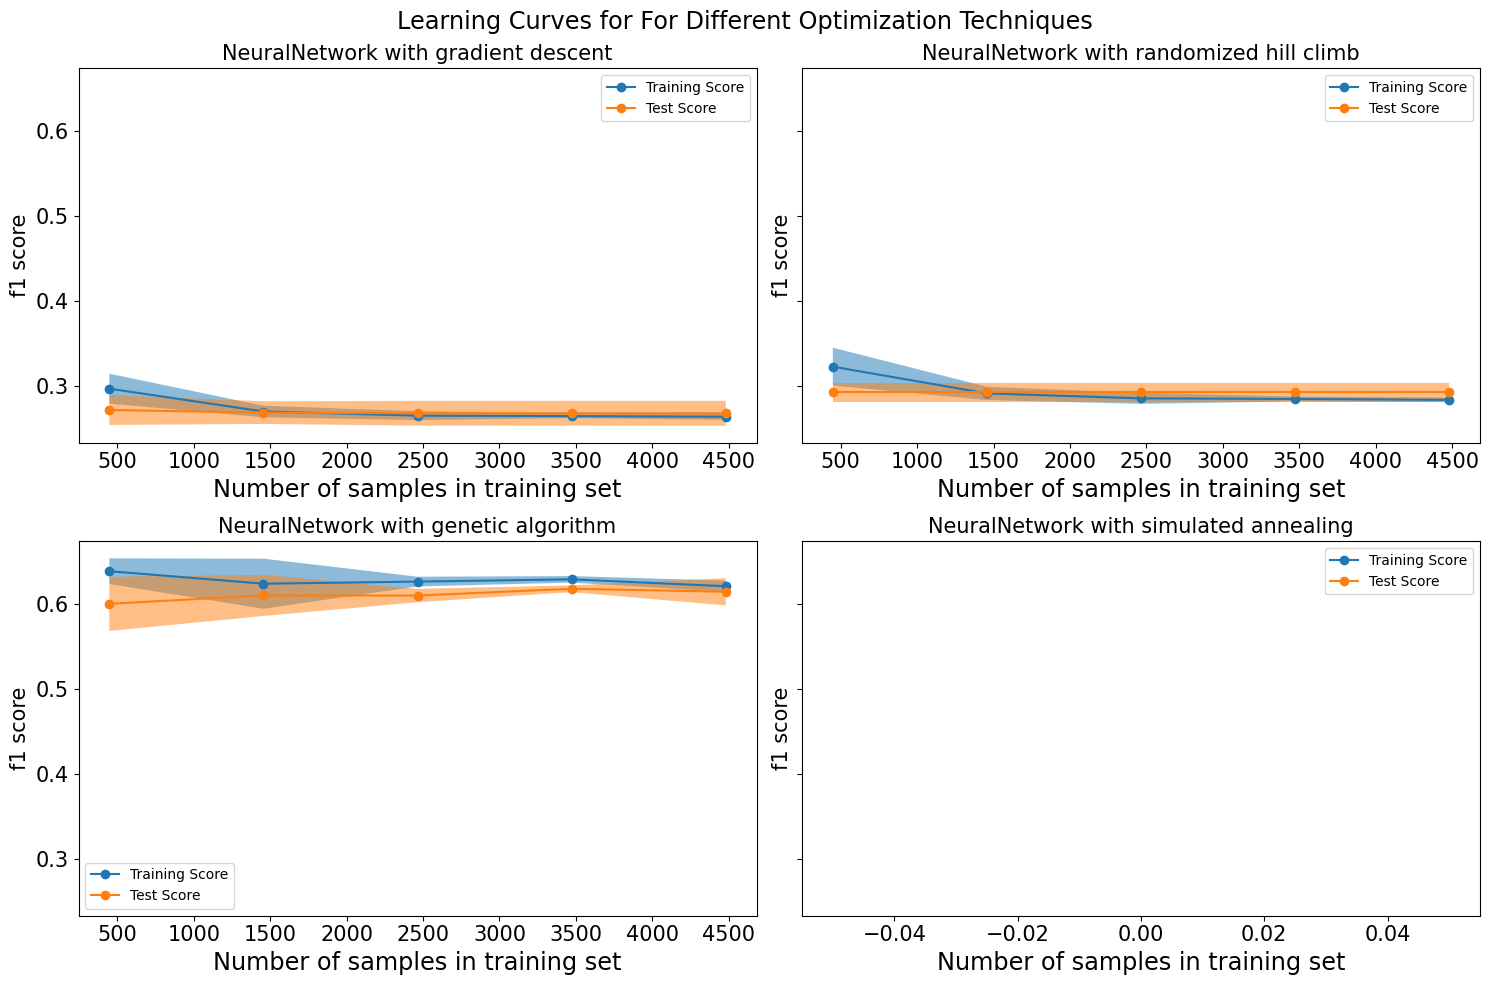

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)
ax = ax.flatten()
# fig.delaxes(ax[4])
# fig.delaxes(ax[5])

common_params = {
    "X": x_shroom_train.to_numpy(),
    "y": np.array(y_train_hot),
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    # "score_name":make_scorer(accuracy_score),
    "score_type": "both",
    "n_jobs": -1,
}

name_lst = ['gradient descent', 'randomized hill climb', 'genetic algorithm', 'simulated annealing']
for ax_idx, estimator in enumerate([nn_gd, nn_rhc,nn_ga, nn_sa]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"{estimator.__class__.__name__} with {name_lst[ax_idx]}", fontsize=15)
    ax[ax_idx].set_xlabel('Number of samples in training set', fontsize='xx-large')
    ax[ax_idx].set_ylabel('f1 score',fontsize = 15)
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=15)
    ax[ax_idx].tick_params(axis='both', which='minor', labelsize=15)
fig.suptitle('Learning Curves for For Different Optimization Techniques', fontsize='xx-large')
plt.tight_layout()

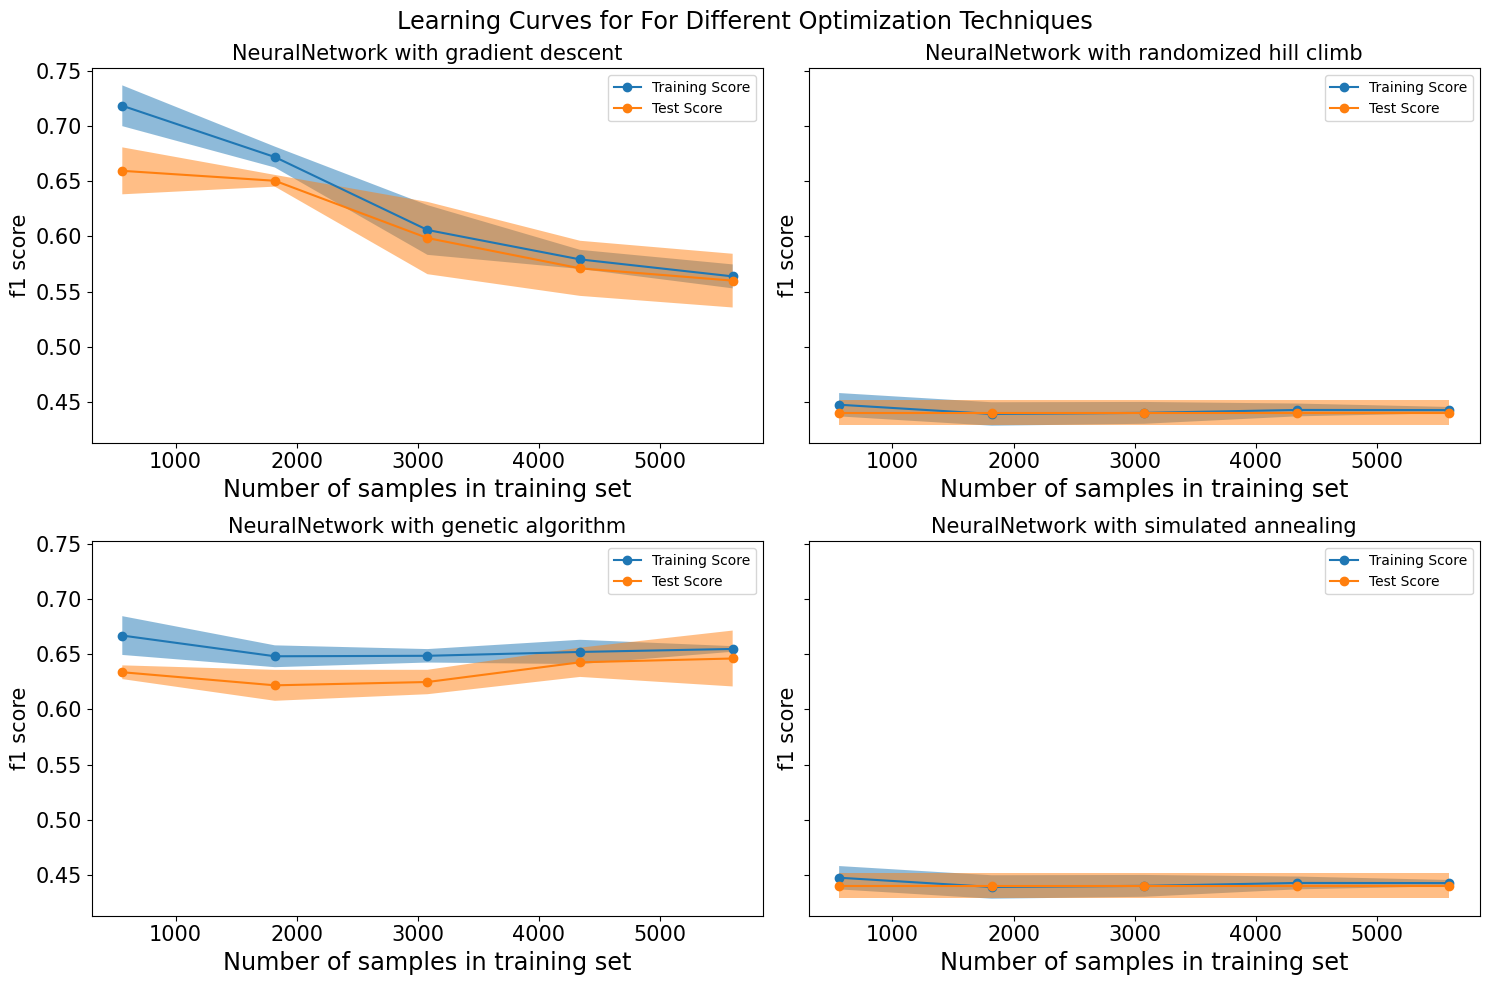

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)
ax = ax.flatten()
# fig.delaxes(ax[4])
# fig.delaxes(ax[5])

common_params = {
    "X": x_shroom_train.to_numpy(),
    "y": np.array(y_train_hot),
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    # "score_name":make_scorer(accuracy_score),
    "score_type": "both",
    "n_jobs": -1,
}

name_lst = ['gradient descent', 'randomized hill climb', 'genetic algorithm', 'simulated annealing']
for ax_idx, estimator in enumerate([nn_gd, nn_rhc,nn_ga, nn_sa]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"{estimator.__class__.__name__} with {name_lst[ax_idx]}", fontsize=15)
    ax[ax_idx].set_xlabel('Number of samples in training set', fontsize='xx-large')
    ax[ax_idx].set_ylabel('f1 score',fontsize = 15)
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=15)
    ax[ax_idx].tick_params(axis='both', which='minor', labelsize=15)
fig.suptitle('Learning Curves for For Different Optimization Techniques', fontsize='xx-large')
plt.tight_layout()

In [13]:
train_sizes_sa, train_scores_sa, test_scores_sa, fit_times_sa, score_times_sa = learning_curve(
    nn_sa, x_shroom_train.to_numpy(), np.array(y_train_hot), cv=5, n_jobs=-1, train_sizes=np.linspace(0.05, 1.0, 10),
      return_times=True, random_state=123456
)

In [4]:
train_sizes_ga, train_scores_ga, test_scores_ga, fit_times_ga, score_times_ga = learning_curve(
    nn_ga, x_shroom_train.to_numpy(), np.array(y_train_hot), cv=5, n_jobs=-1, train_sizes=np.linspace(0.05, 1.0, 10),
      return_times=True, random_state=123456
)

train_sizes_rhc, train_scores_rhc, test_scores_rhc, fit_times_rhc, score_times_rhc = learning_curve(
    nn_rhc, x_shroom_train.to_numpy(), np.array(y_train_hot), cv=5, n_jobs=-1, train_sizes=np.linspace(0.05, 1.0, 10),
      return_times=True, random_state=123456
)

train_sizes_gd, train_scores_gd, test_scores_gd, fit_times_gd, score_times_gd = learning_curve(
    nn_gd, x_shroom_train.to_numpy(), np.array(y_train_hot), cv=5, n_jobs=-1, train_sizes=np.linspace(0.05, 1.0, 10), 
    return_times=True, random_state=123456
)

In [10]:
# genetic algo curves
pd.DataFrame(train_sizes_ga).to_csv('ga_train_sizes.csv')
pd.DataFrame(train_scores_ga).to_csv('ga_train_scores.csv')
pd.DataFrame(test_scores_ga).to_csv('ga_test_scores.csv')
pd.DataFrame(fit_times_ga).to_csv('ga_fit_times.csv')
pd.DataFrame(score_times_ga).to_csv('ga_score_times.csv')

In [11]:
# randomized hill climbing curves
pd.DataFrame(train_sizes_rhc).to_csv('rhc_train_sizes.csv')
pd.DataFrame(train_scores_rhc).to_csv('rhc_train_scores.csv')
pd.DataFrame(test_scores_rhc).to_csv('rhc_test_scores.csv')
pd.DataFrame(fit_times_rhc).to_csv('rhc_fit_times.csv')
pd.DataFrame(score_times_rhc).to_csv('rhc_score_times.csv')

In [12]:
# gradient descent curves
pd.DataFrame(train_sizes_gd).to_csv('gd_train_sizes.csv')
pd.DataFrame(train_scores_gd).to_csv('gd_train_scores.csv')
pd.DataFrame(test_scores_gd).to_csv('gd_test_scores.csv')
pd.DataFrame(fit_times_gd).to_csv('gd_fit_times.csv')
pd.DataFrame(score_times_gd).to_csv('gd_score_times.csv')

In [14]:
# sim anneal curves
pd.DataFrame(train_sizes_sa).to_csv('sa_train_sizes.csv')
pd.DataFrame(train_scores_sa).to_csv('sa_train_scores.csv')
pd.DataFrame(test_scores_sa).to_csv('sa_test_scores.csv')
pd.DataFrame(fit_times_sa).to_csv('sa_fit_times.csv')
pd.DataFrame(score_times_sa).to_csv('sa_score_times.csv')

## Time Complexity Curves

In [23]:
# sklearn citatio: https://scikit-learn.org/1.0/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    X,
    y,
    axes=None,
    cv=None,
    n_jobs=-1,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    name = 'neural_net'
):


    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    scoring_times_mean = np.mean(score_times, axis=1)
    scoring_times_std = np.std(score_times, axis=1)

    # Plot n_samples vs fit_times
    line = axes.plot(train_sizes, fit_times_mean, "o-")
    axes.fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )

    # Plot n_samples vs query_times
    axes.plot(train_sizes, scoring_times_mean, "o-")
    axes.fill_between(
        train_sizes,
        scoring_times_mean - scoring_times_std,
        scoring_times_mean + scoring_times_std,
        alpha=0.1,
    )
    axes.set_xlabel("Training Examples", fontsize = 15)
    axes.set_ylabel("Time (seconds)", fontsize = 15)
    axes.set_title(f"Time Complexity of {name}", fontsize = 15)
    axes.legend(["Training Time", "Query Time"], loc='upper right')
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.tick_params(axis='both', which='minor', labelsize=15)

    return line

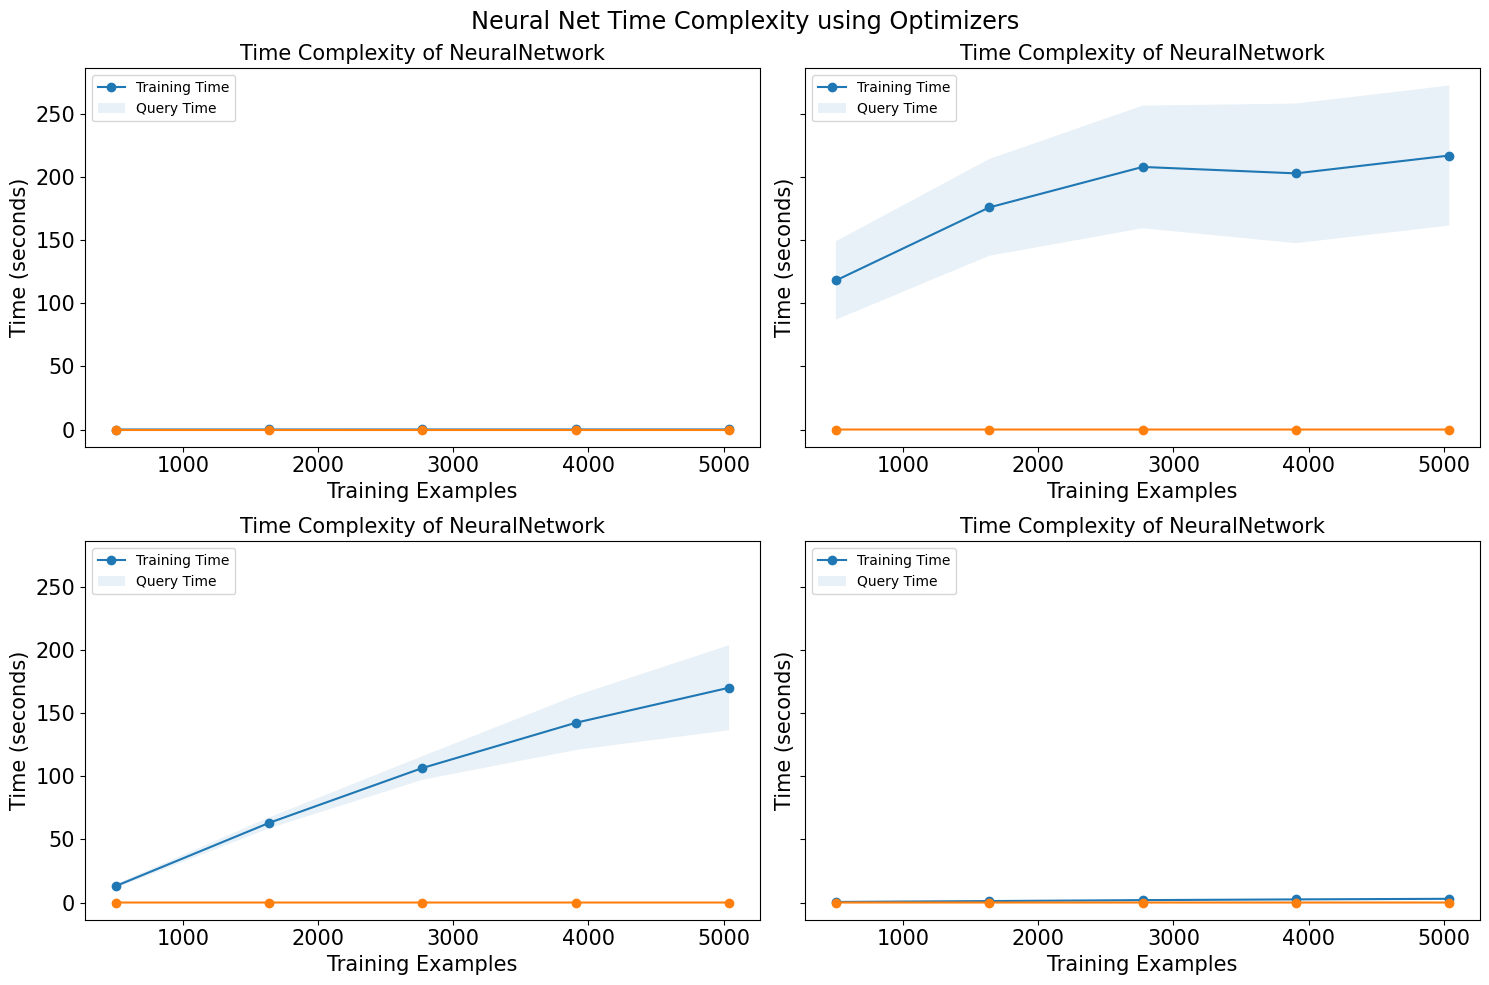

In [24]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15,10), sharey=True)
axs = axs.flatten()
train_size_lst = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit()
plot_learning_curve(
    nn_sa,
    x_shroom_train.to_numpy(),
    np.array(y_train_hot),
    axes=axs[0],
    cv=cv,
    scoring='f1',
    train_sizes= train_size_lst,
    name='sim_anneal_nn'
)
plot_learning_curve(
    nn_ga,
    x_shroom_train.to_numpy(),
    np.array(y_train_hot),
    axes=axs[1],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
    name='genetic_algo_nn'
)
plot_learning_curve(
    nn_rhc,
    x_shroom_train.to_numpy(),
    np.array(y_train_hot),
    axes=axs[2],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
    name='random_hill_nn'
)

plot_learning_curve(
    nn_gd,
    x_shroom_train.to_numpy(),
    np.array(y_train_hot),
    axes=axs[3],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
    name='gradient_descent_nn'
)

fig.suptitle('Neural Net Time Complexity using Optimizers', fontsize='xx-large')
fig.tight_layout()
plt.show()

## Neural Network Hyperparameter Tuning

In [29]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    "max_iters": [20, 50, 100, 200],                 # nn params
    'learning_rate': [0.001, 0.01, 1],
    'schedule': [mlrose.ArithDecay(20), mlrose.ArithDecay(40), mlrose.ArithDecay(60)]
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='sim_annealing',
                    algorithm=mlrose.algorithms.sa.simulated_annealing,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100, 150, 200],
                    hidden_layer_sizes=[[100],[100,100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df_sa, curves_df_sa, cv_results_df_sa, sr_sa = nnr.run()          # GridSearchCV instance returned   

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [30]:
curves_df_sa.head(3)

,Iteration,Time,Fitness,FEvals,max_iters,is_classifier,learning_rate,schedule,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.054590,16.032989,2.0,20,True,0.001,20,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,False,1.000000e+10,"[100, 100]",0.1,20
1,1,0.155869,16.032989,4.0,20,True,0.001,20,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,False,1.000000e+10,"[100, 100]",0.1,20
2,2,0.241317,16.032989,6.0,20,True,0.001,20,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,False,1.000000e+10,"[100, 100]",0.1,20


In [31]:
sr_sa.best_estimator_

NNClassifier(activation=<function relu at 0x0000024CC06823B0>,
             algorithm=<function simulated_annealing at 0x0000024CC0680B80>,
             hidden_layer_sizes=[100, 100], is_classifier=True,
             learning_rate=0.001, max_attempts=500, max_iters=20,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x0000024C9F016920>,
             schedule=ArithDecay(init_temp=20, decay=0.0001, min_temp=0.001),
             seed=123456)

In [15]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    "max_iters": [20, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 1],
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='nn_test',
                    algorithm=mlrose.algorithms.ga.genetic_alg,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100, 150, 200],
                    hidden_layer_sizes=[[100],[100,100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df_ga, curves_df_ga, cv_results_df_ga, sr_ga = nnr.run() 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [24]:
sr_ga.best_estimator_

NNClassifier(activation=<function relu at 0x0000024CC06823B0>,
             algorithm=<function genetic_alg at 0x0000024CC0680A60>,
             hidden_layer_sizes=[100], is_classifier=True, learning_rate=0.001,
             max_attempts=500, max_iters=200,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x0000024CC2EE5AB0>,
             seed=123456)

In [16]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    "max_iters": [20, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 1],
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='rhc',
                    algorithm=mlrose.algorithms.rhc.random_hill_climb,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100, 150, 200],
                    hidden_layer_sizes=[[100],[100,100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df_rhc, curves_df_rhc, cv_results_df_rhc, sr_rhc = nnr.run()          # GridSearchCV instance returned   

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [23]:
sr_rhc.best_estimator_

NNClassifier(activation=<function relu at 0x0000024CC06823B0>,
             algorithm=<function random_hill_climb at 0x0000024CC0682050>,
             hidden_layer_sizes=[100, 100], is_classifier=True,
             learning_rate=0.001, max_attempts=500, max_iters=20,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x0000024CC2EE6020>,
             seed=123456)

In [17]:
# Tune max_iters and learning_rate_init
grid_search = {
    "max_iters": [20, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 1],
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
}

runner = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name="gradient_descent",
                    algorithm=mlrose.algorithms.gradient_descent,
                    grid_search_parameters=grid_search,
                    iteration_list=[100, 150, 200],
                    hidden_layer_sizes=[[100],[100,100]],
                    bias=True,
                    early_stopping=True,
                    clip_max=1,
                    max_attempts=1000,
                    generate_curves=True,
                    seed=123456,
                    n_jobs=-1
                          )
run_stats_gd, curves_gd, cv_results_gd, best_est_gd = runner.run()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [22]:
best_est_gd.best_estimator_

NNClassifier(activation=<function relu at 0x0000024CC06823B0>,
             algorithm=<function gradient_descent at 0x0000024CC0681BD0>,
             clip_max=1, early_stopping=True, hidden_layer_sizes=[100],
             is_classifier=True, learning_rate=0.001, max_attempts=1000,
             max_iters=20,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x0000024CC2387EB0>,
             seed=123456)

## Define Fitness Functions

### Neural Network

In [9]:
nn = NeuralNetwork(hidden_nodes = [100], activation = 'relu', 
                                    algorithm = 'random_hill_climb', 
                                    max_iters = 1000, bias = True, is_classifier = True, 
                                    learning_rate = 0.01, early_stopping = True, 
                                    clip_max = 5, max_attempts = 10, random_state = 3,
                                    restarts=5)

In [10]:
# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_shroom_train.to_numpy().reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_shroom_test.to_numpy().reshape(-1, 1)).todense()

In [35]:
nn.fit(x_shroom_train, y_train_hot)

NeuralNetwork(activation='sigmoid', clip_max=5, early_stopping=True,
              hidden_nodes=[100], learning_rate=0.01, max_attempts=100,
              max_iters=1000, random_state=3)

In [12]:
train_sizes_rhc, train_scores_rhc, test_scores_rhc, fit_times_rhc, score_times_rhc =\
      learning_curve(nn, x_shroom_train.to_numpy(), np.array(y_train_hot),
                      cv=3, n_jobs=-1,train_sizes=np.linspace(0.05, 1.0, 3),
                    return_times=True, random_state=123456
                    )

print(train_scores_rhc.mean(axis=1))
print(test_scores_rhc.mean(axis=1))

In [43]:
results = nn.predict(x_shroom_test)

In [44]:
results

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [51]:
from sklearn.metrics import f1_score
f1_score(np.array(y_test_hot), results, average='weighted')

0.5231627031151295